In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install netCDF4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 29.0 MB/s eta 0:00:00


# CNN

Device: cuda


<ipython-input-5-45818da9bfae>:57: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  return torch.tensor(inputs, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32).unsqueeze(1)


Epoch 1/20, Loss: 116.8828


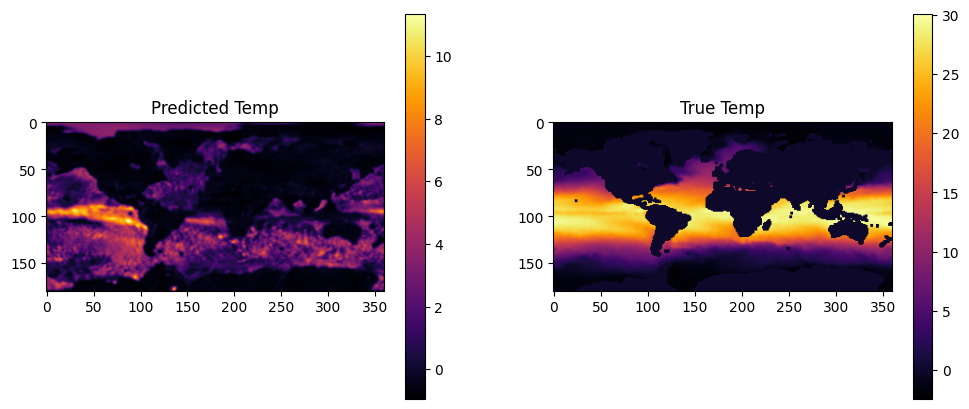

Epoch 2/20, Loss: 94.0590


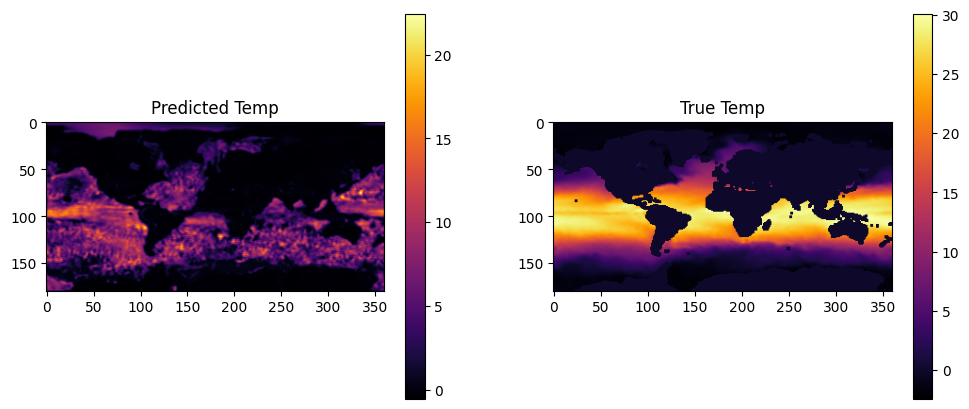

Epoch 3/20, Loss: 73.6632


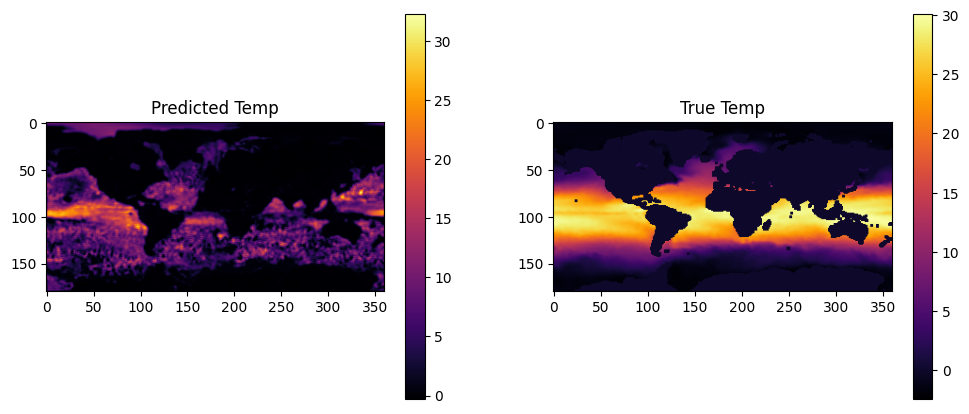

Epoch 4/20, Loss: 59.3502


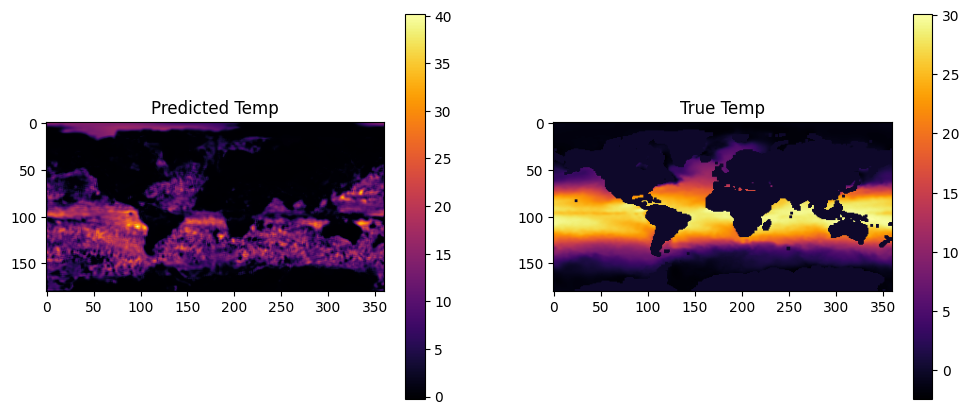

Epoch 5/20, Loss: 50.6074


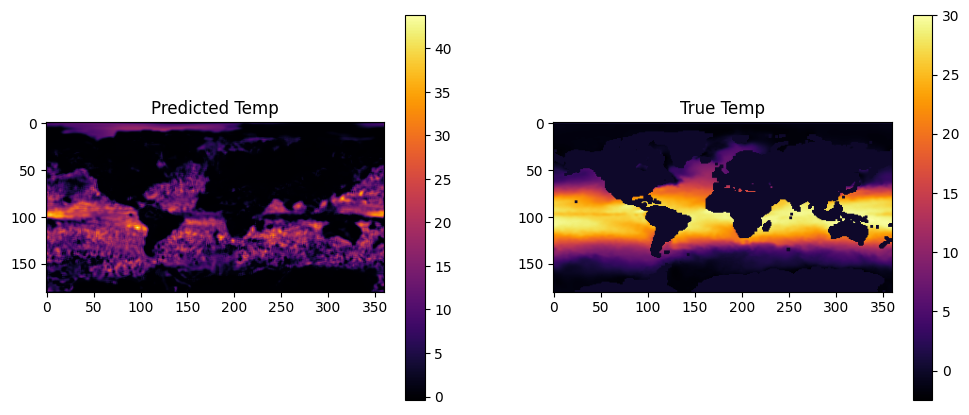

Epoch 6/20, Loss: 46.2279


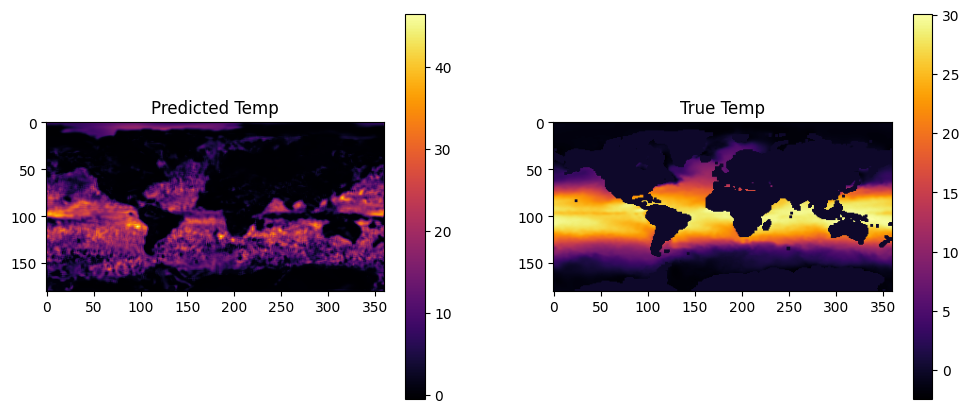

Epoch 7/20, Loss: 43.2202


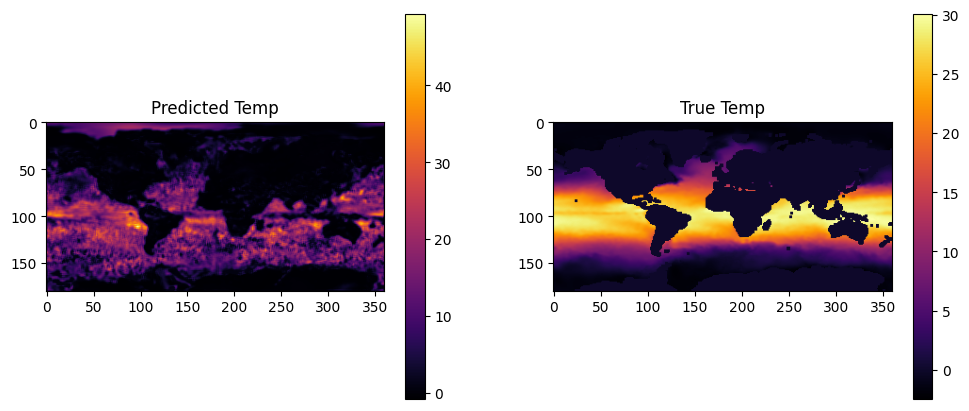

Epoch 8/20, Loss: 41.8977


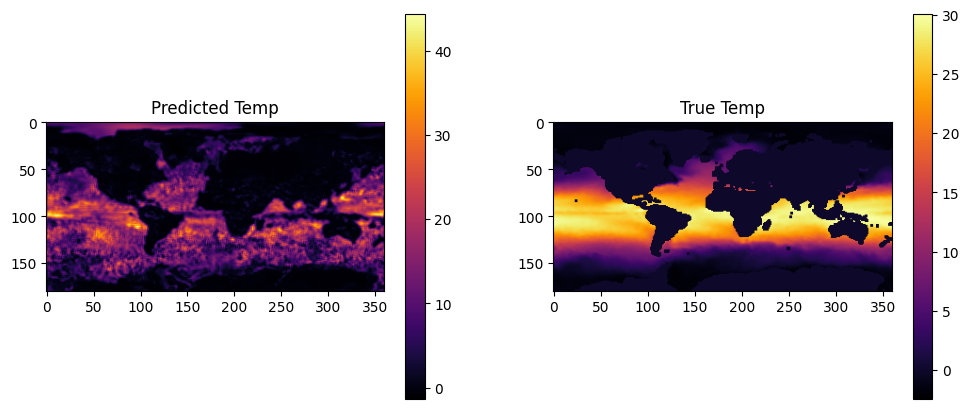

Epoch 9/20, Loss: 40.8053


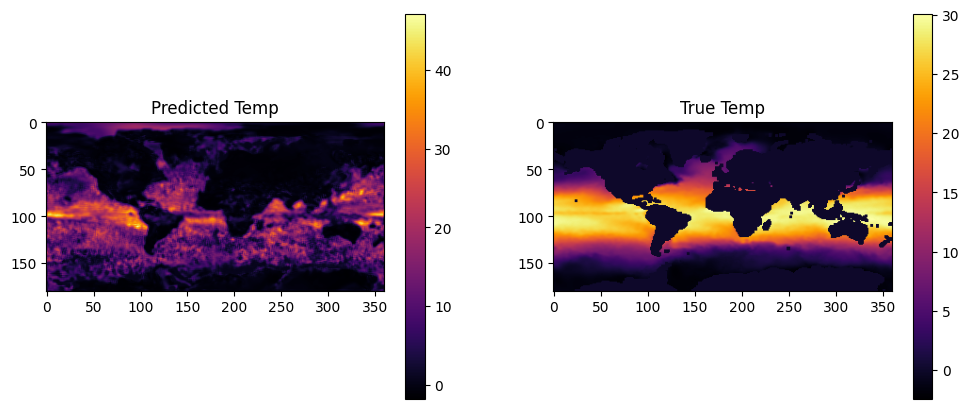

Epoch 10/20, Loss: 39.6903


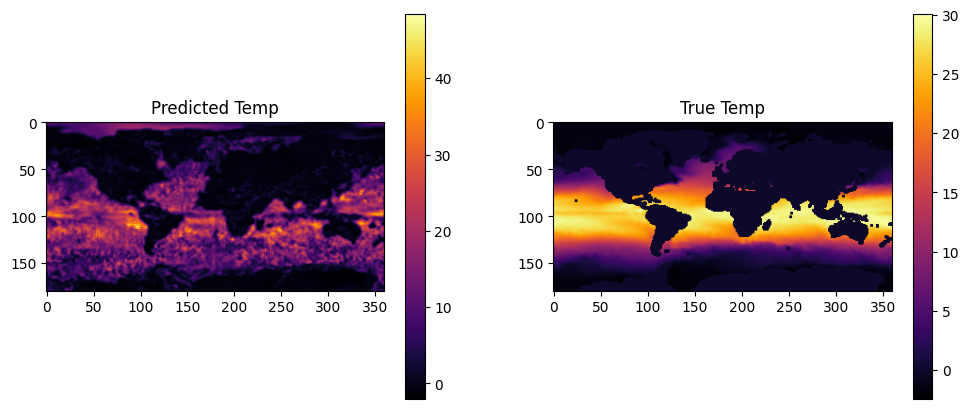

Epoch 11/20, Loss: 38.4847


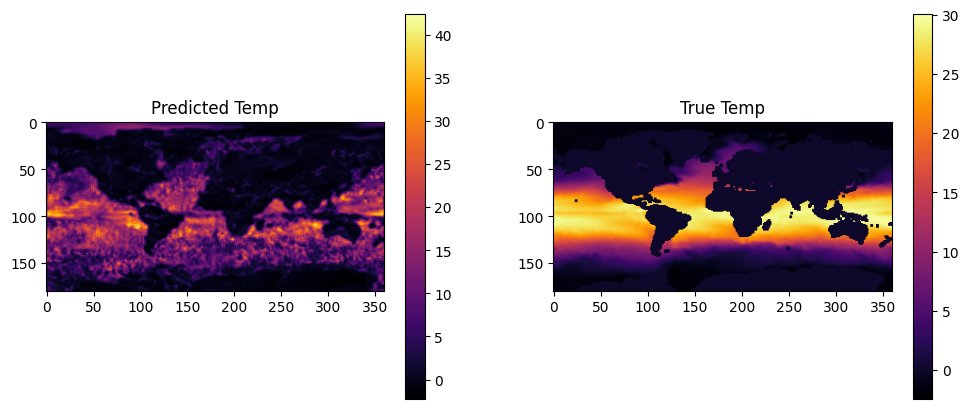

Epoch 12/20, Loss: 37.6598


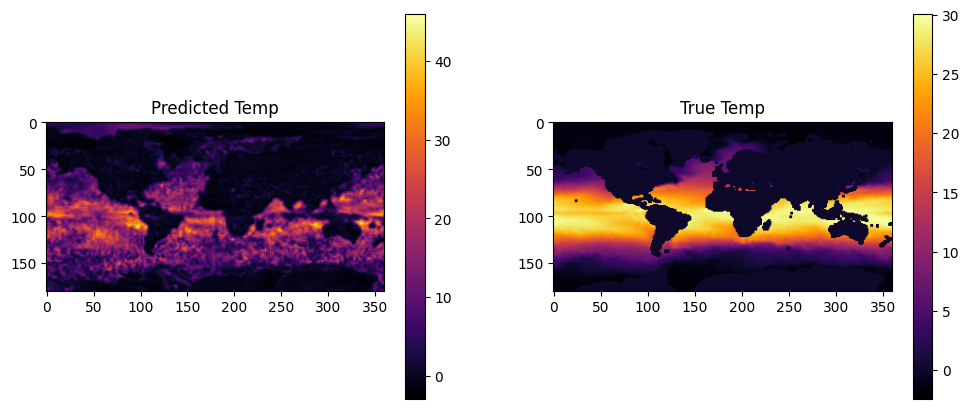

Epoch 13/20, Loss: 37.2539


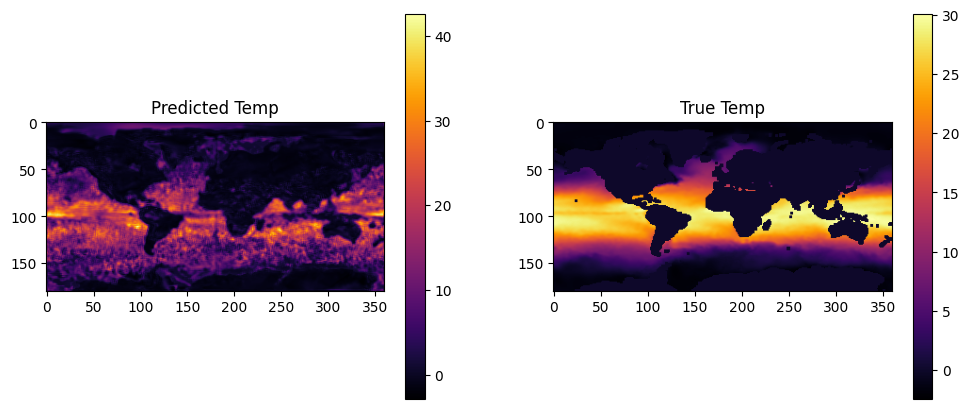

Epoch 14/20, Loss: 36.6179


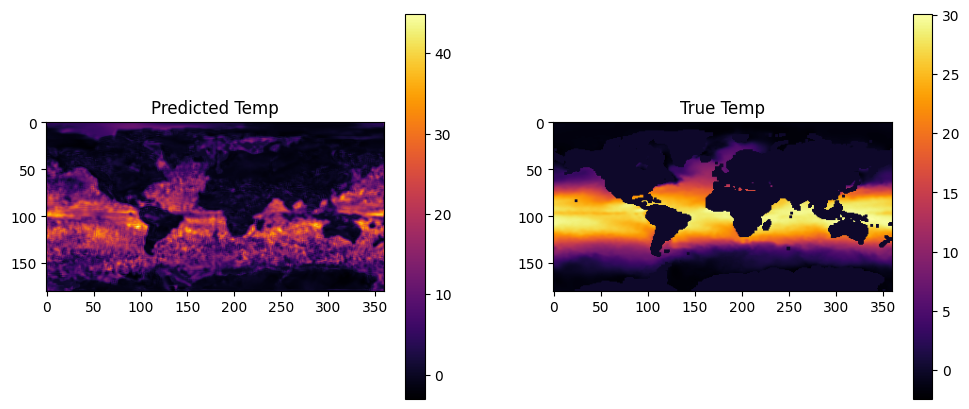

Epoch 15/20, Loss: 36.5733


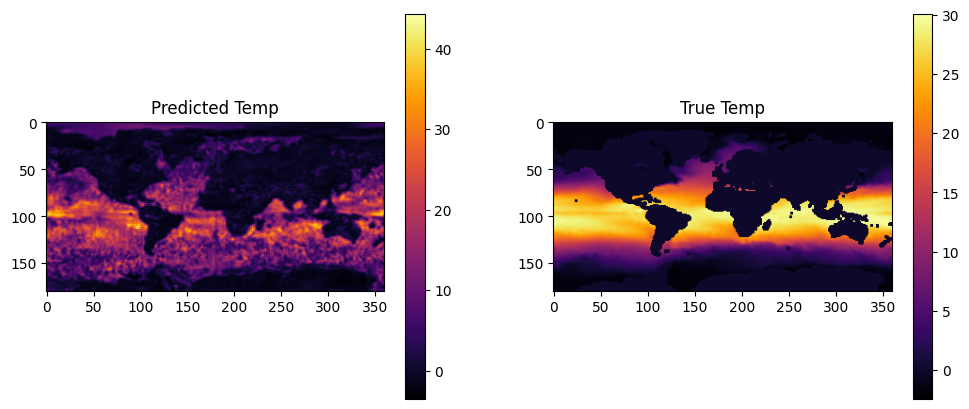

Epoch 16/20, Loss: 35.8271


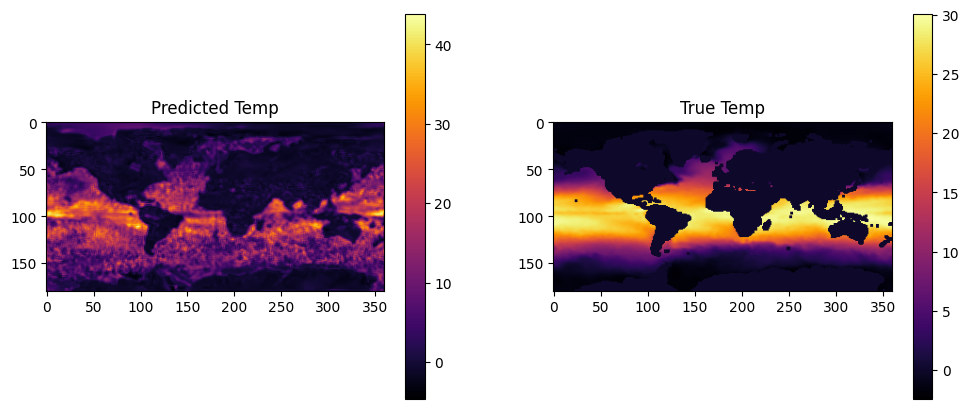

Epoch 17/20, Loss: 35.3220


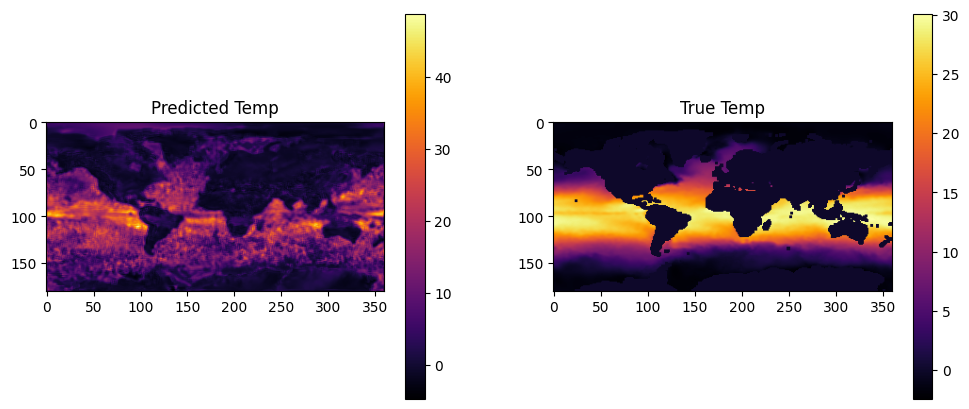

Epoch 18/20, Loss: 35.9400


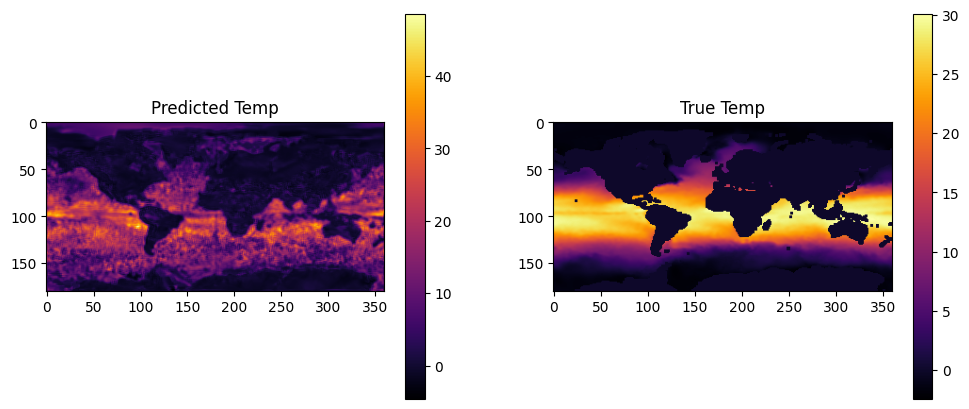

Epoch 19/20, Loss: 34.3077


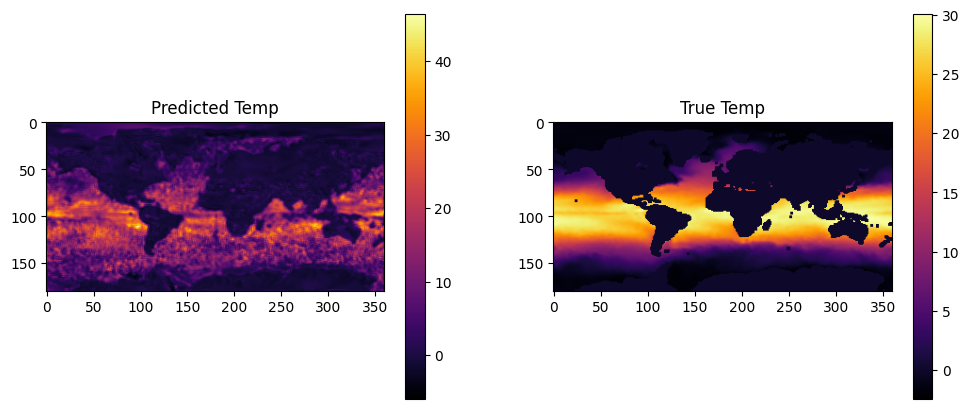

Epoch 20/20, Loss: 33.9650


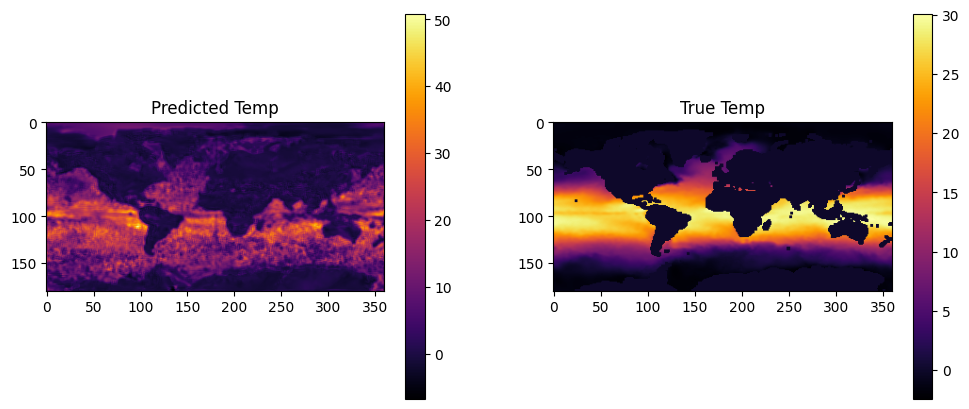

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import netCDF4
import os
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ============ Data Preprocessing ============
sequence_len = 3

class OceanDataset(Dataset):
    def __init__(self, file_paths, sequence_length=sequence_len):
        self.sequence_length = sequence_length
        self.features, self.targets = self.load_data(file_paths)

    def load_data(self, file_paths):
        def read_var(path, var):
            data = netCDF4.Dataset(path)[var][:].filled(np.nan)
            return data

        SSH = read_var(file_paths['SSH'], 'SSH')
        SST = read_var(file_paths['SST'], 'SST')
        uSSW = read_var(file_paths['uSSW'], 'uSSW')
        vSSW = read_var(file_paths['vSSW'], 'vSSW')
        ST = read_var(file_paths['depth1'], 'ST')

        from skimage.transform import resize
        SSH = resize(SSH, (SSH.shape[0], 180, 360), preserve_range=True)
        SST = resize(SST, (SST.shape[0], 180, 360), preserve_range=True)
        uSSW = resize(uSSW, (uSSW.shape[0], 180, 360), preserve_range=True)
        vSSW = resize(vSSW, (vSSW.shape[0], 180, 360), preserve_range=True)
        ST = resize(ST, (ST.shape[0], 180, 360), preserve_range=True)

        X = np.stack([SSH, SST, uSSW, vSSW], axis=1)
        y = ST

        X = np.nan_to_num(X)
        y = np.nan_to_num(y)

        scaler = StandardScaler()
        T, C, H, W = X.shape
        X = X.reshape(T, -1)
        X = scaler.fit_transform(X).reshape(T, C, H, W)

        inputs, targets = [], []
        for i in range(self.sequence_length, T):
            inputs.append(X[i-self.sequence_length:i])
            targets.append(y[i])

        return torch.tensor(inputs, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

# ============ CNN Model ============
class DepthCNN(nn.Module):
    def __init__(self, seq_len, in_channels, hidden_dim):
        super(DepthCNN, self).__init__()
        # combine time and channel dims
        self.total_in_ch = seq_len*in_channels
        self.conv1 = nn.Conv2d(self.total_in_ch, hidden_dim, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(hidden_dim)
        self.conv2 = nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(hidden_dim)
        self.conv_out = nn.Conv2d(hidden_dim, 1, kernel_size=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        # x: (B, T, C, H, W)
        B, T, C, H, W = x.size()
        # reshape to (B, T*C, H, W)
        x = x.view(B, T * C, H, W)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        out = self.conv_out(x)
        return out

# ============ Training Loop ============
def train_model(model, train_loader, test_loader, epochs=10):
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()
    model.to(device)

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss/len(train_loader):.4f}")

        # Evaluation
        model.eval()
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                preds = model(inputs)
                break

        pred_img = preds[0, 0].cpu().numpy()
        true_img = targets[0, 0].cpu().numpy()

        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(np.flipud(pred_img.squeeze()), cmap='inferno')
        plt.title("Predicted Temp")
        plt.colorbar()
        plt.subplot(1, 2, 2)
        plt.imshow(np.flipud(true_img.squeeze()), cmap='inferno')
        plt.title("True Temp")
        plt.colorbar()
        plt.show()

# ============ Run ============
file_paths = {
    'SSH': '/content/drive/MyDrive/661 Final Project/project_SSH_1992-2021.nc',
    'SST': '/content/drive/MyDrive/661 Final Project/project_SST_1992-2021.nc',
    'uSSW': '/content/drive/MyDrive/661 Final Project/project_uSSW_1992-2021.nc',
    'vSSW': '/content/drive/MyDrive/661 Final Project/project_vSSW_1992-2021.nc',
    'depth1': '/content/drive/MyDrive/661 Final Project/project_ST_1992-2021_dep-1.nc'
}

batch_size = 4

full_dataset = OceanDataset(file_paths, sequence_length=sequence_len)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# model = ConvLSTM(input_dim=4, hidden_dim=32, kernel_size=7, num_layers=2)
model = DepthCNN(seq_len=3, in_channels=4,
                 hidden_dim=32)
train_model(model, train_loader, test_loader, epochs=20)

# Spearman

In [ ]:
from scipy.stats import spearmanr

# ============ Testing the Model with Spearman ============
def evaluate_model_with_spearman(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_targets = []

    with torch.no_grad():  # Disable gradient computation
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            preds = model(inputs)

            # Convert predictions and targets to numpy arrays
            all_preds.append(preds.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    # Convert the list of arrays into a single array
    all_preds = np.concatenate(all_preds, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)

    # Flatten the arrays to compute metrics
    all_preds_flat = all_preds.flatten()
    all_targets_flat = all_targets.flatten()

    # Calculate Spearman's rank correlation
    spearman_corr, _ = spearmanr(all_preds_flat, all_targets_flat)

    print(f"Spearman Rank Correlation Coefficient: {spearman_corr:.4f}")

    # You can also visualize the predicted vs. true temperature for one of the test samples
    pred_img = all_preds[0, 0]  # Visualize the first test sample's prediction
    true_img = all_targets[0, 0]  # True values for comparison

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(np.flipud(pred_img.squeeze()), cmap='inferno')
    plt.title("Predicted Temp")
    plt.colorbar()
    plt.subplot(1, 2, 2)
    plt.imshow(np.flipud(true_img.squeeze()), cmap='inferno')
    plt.title("True Temp")
    plt.colorbar()
    plt.show()

# ============ Run Evaluation with Spearman ============
evaluate_model_with_spearman(model, test_loader)

# LSTM

Device: cuda
Epoch 1/10, Loss: 100.1819


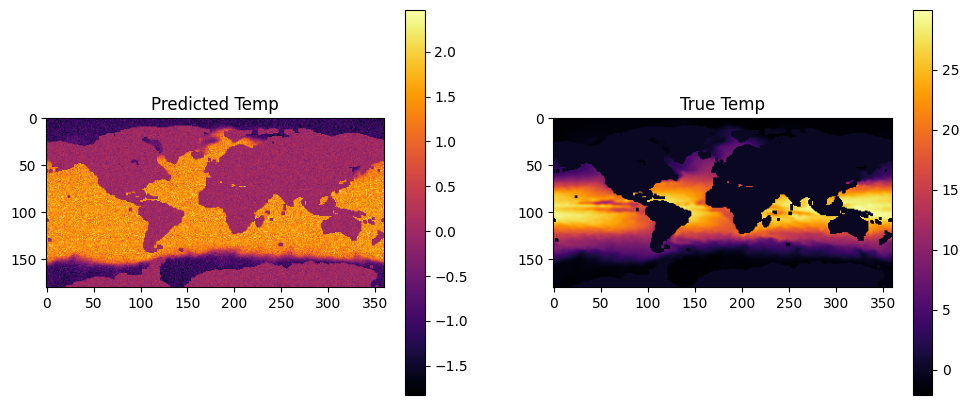

Epoch 2/10, Loss: 76.7421


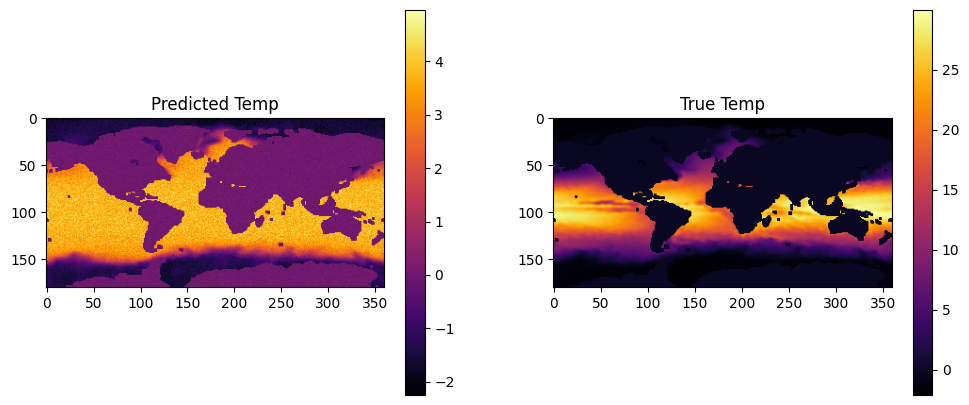

Epoch 3/10, Loss: 55.7075


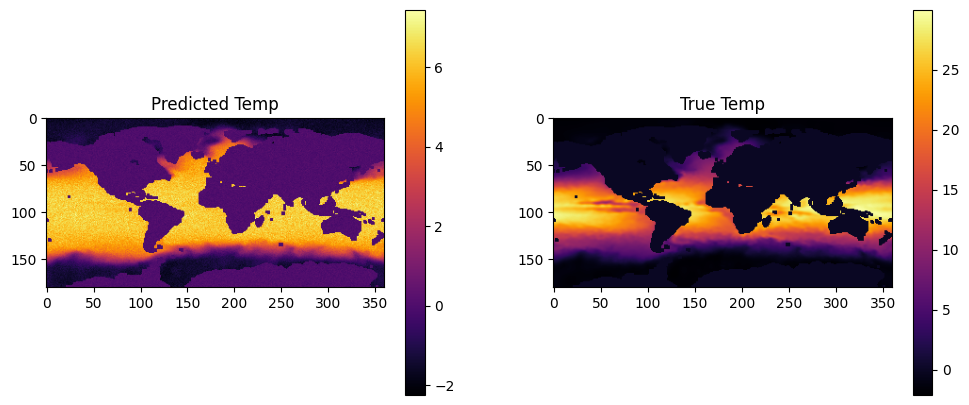

Epoch 4/10, Loss: 39.4893


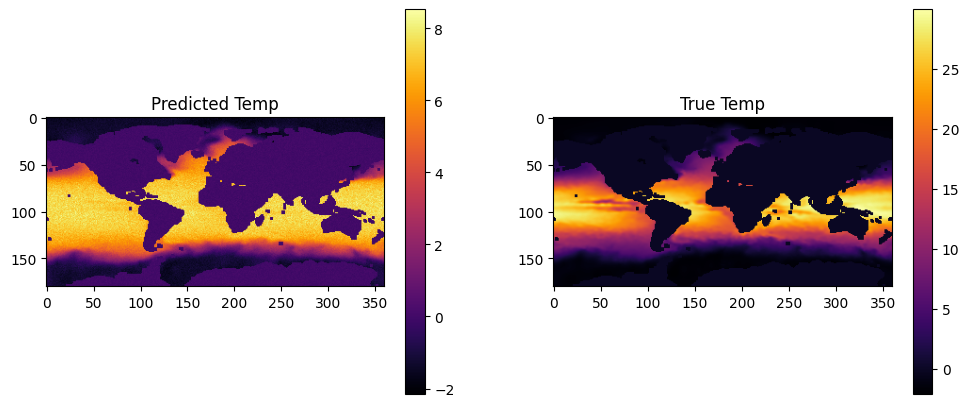

Epoch 5/10, Loss: 27.6147


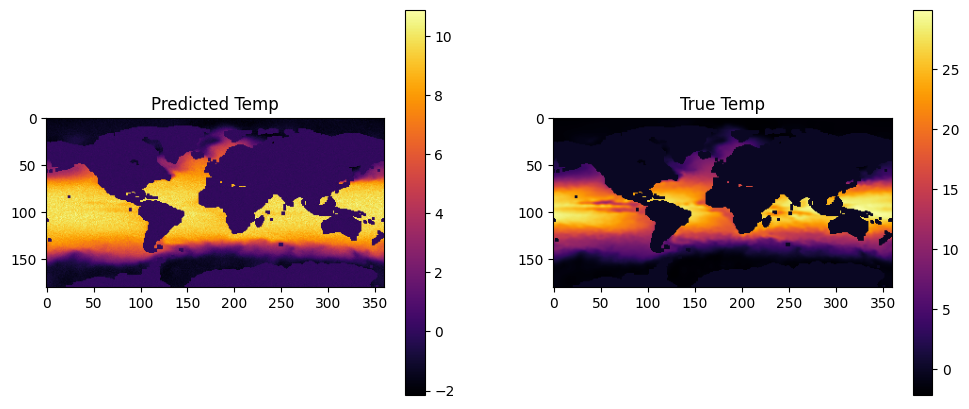

Epoch 6/10, Loss: 19.5441


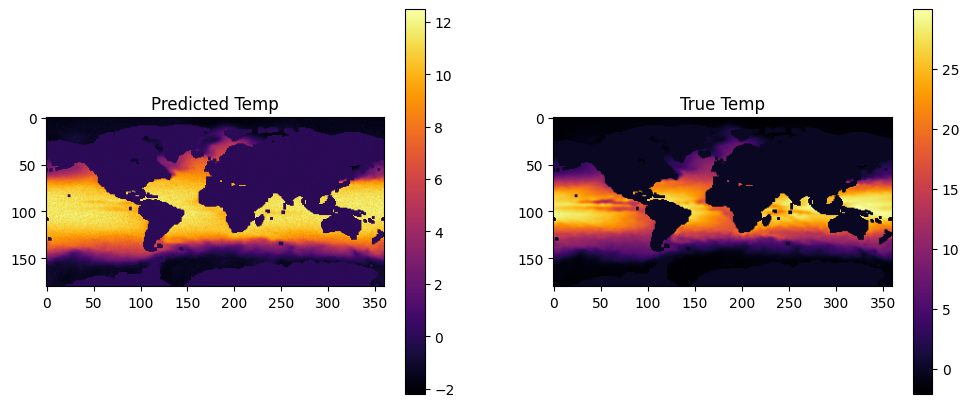

Epoch 7/10, Loss: 13.4323


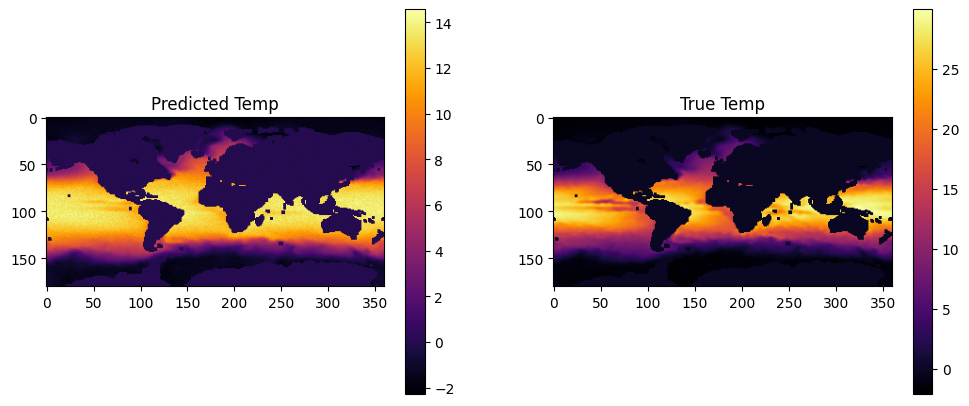

Epoch 8/10, Loss: 9.0596


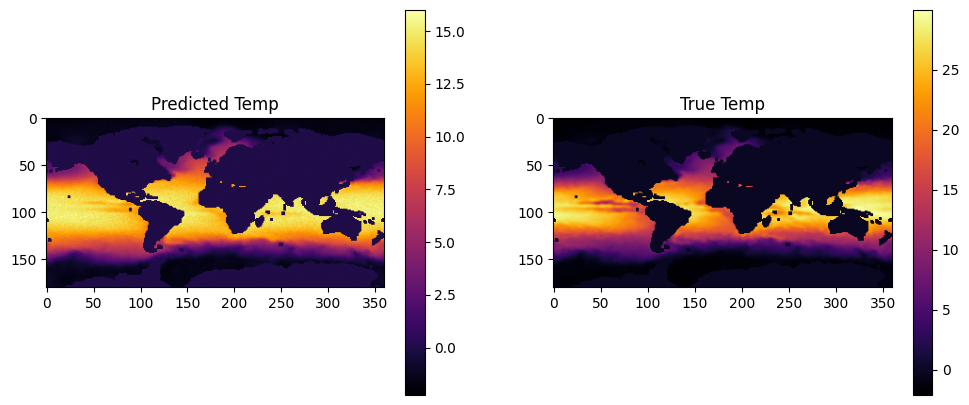

Epoch 9/10, Loss: 6.3754


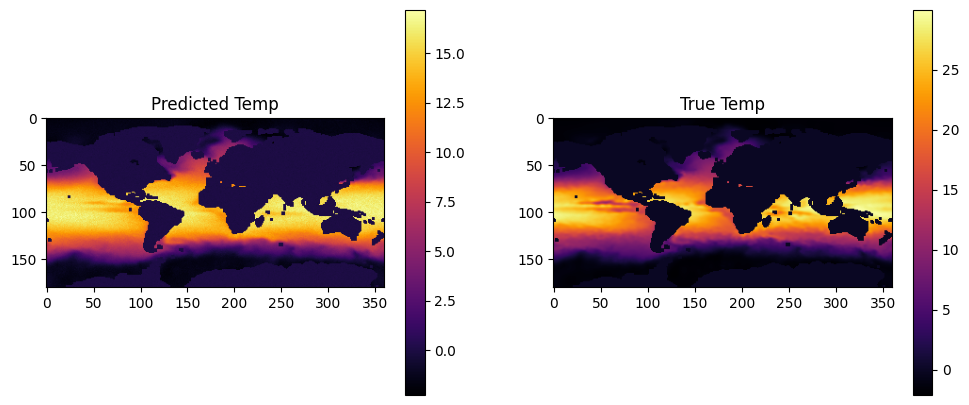

Epoch 10/10, Loss: 4.4823


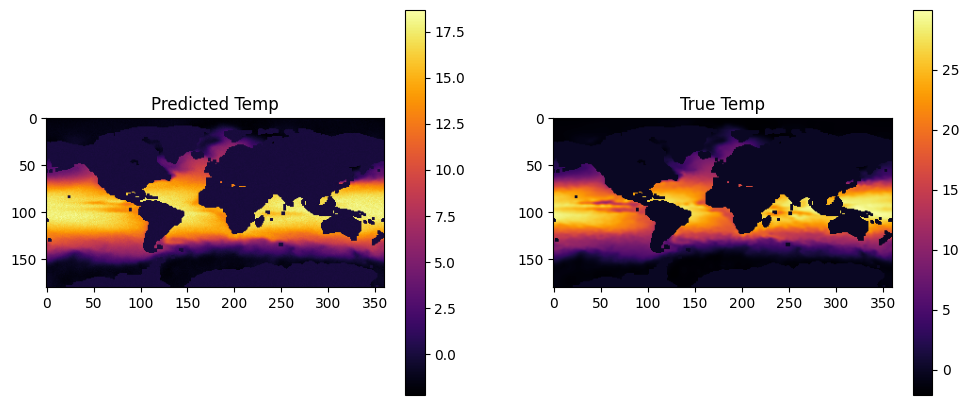

Spearman Rank Correlation Coefficient: 0.9355


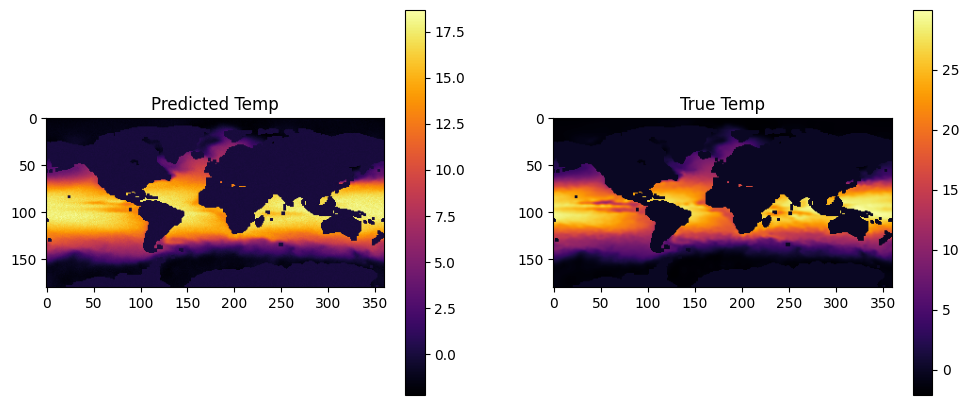

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import netCDF4
import os
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ============ Data Preprocessing ============
sequence_len = 3

class OceanDataset(Dataset):
    def __init__(self, file_paths, sequence_length=sequence_len):
        self.sequence_length = sequence_length
        self.features, self.targets = self.load_data(file_paths)

    def load_data(self, file_paths):
        def read_var(path, var):
            data = netCDF4.Dataset(path)[var][:].filled(np.nan)
            return data

        SSH = read_var(file_paths['SSH'], 'SSH')
        SST = read_var(file_paths['SST'], 'SST')
        uSSW = read_var(file_paths['uSSW'], 'uSSW')
        vSSW = read_var(file_paths['vSSW'], 'vSSW')
        ST = read_var(file_paths['depth1'], 'ST')

        from skimage.transform import resize
        SSH = resize(SSH, (SSH.shape[0], 180, 360), preserve_range=True)
        SST = resize(SST, (SST.shape[0], 180, 360), preserve_range=True)
        uSSW = resize(uSSW, (uSSW.shape[0], 180, 360), preserve_range=True)
        vSSW = resize(vSSW, (vSSW.shape[0], 180, 360), preserve_range=True)
        ST = resize(ST, (ST.shape[0], 180, 360), preserve_range=True)

        X = np.stack([SSH, SST, uSSW, vSSW], axis=1)
        y = ST

        X = np.nan_to_num(X)
        y = np.nan_to_num(y)

        scaler = StandardScaler()
        T, C, H, W = X.shape
        X = X.reshape(T, -1)
        X = scaler.fit_transform(X).reshape(T, C, H, W)

        inputs, targets = [], []
        for i in range(self.sequence_length, T):
            inputs.append(X[i-self.sequence_length:i])
            targets.append(y[i])

        return torch.tensor(inputs, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

# ============ LSTM Model ============
class DepthLSTM(nn.Module):
    def __init__(self, seq_len, in_channels, hidden_dim, height, width):
        super(DepthLSTM, self).__init__()
        self.seq_len = seq_len
        self.in_channels = in_channels
        self.height = height
        self.width = width
        self.input_dim = in_channels * height * width
        self.hidden_dim = hidden_dim
        # LSTM over time dimension
        self.lstm = nn.LSTM(
            input_size=self.input_dim,
            hidden_size=hidden_dim,
            num_layers=1,
            batch_first=True,
        )
        # Map hidden state to spatial map
        self.fc = nn.Linear(hidden_dim, height * width)

    def forward(self, x):
        # x: (B, T, C, H, W)
        B, T, C, H, W = x.size()
        # Flatten spatial and channel dims: (B, T, C*H*W)
        x = x.view(B, T, C * H * W)
        # LSTM expects (B, T, input_dim)
        output, (h_n, c_n) = self.lstm(x)
        # Take last time step output: (B, hidden_dim)
        last = output[:, -1, :]
        # Project to spatial grid
        out = self.fc(last)  # (B, H*W)
        out = out.view(B, 1, H, W)  # (B, 1, H, W)
        return out

# ============ Training Loop ============
def train_model(model, train_loader, test_loader, epochs=10):
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()
    model.to(device)

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss/len(train_loader):.4f}")

        # Evaluation
        model.eval()
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                preds = model(inputs)
                break

        pred_img = preds[0, 0].cpu().numpy()
        true_img = targets[0, 0].cpu().numpy()

        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(np.flipud(pred_img.squeeze()), cmap='inferno')
        plt.title("Predicted Temp")
        plt.colorbar()
        plt.subplot(1, 2, 2)
        plt.imshow(np.flipud(true_img.squeeze()), cmap='inferno')
        plt.title("True Temp")
        plt.colorbar()
        plt.show()

# ============ Run ============
file_paths = {
    'SSH': '/content/drive/MyDrive/661 Final Project/project_SSH_1992-2021.nc',
    'SST': '/content/drive/MyDrive/661 Final Project/project_SST_1992-2021.nc',
    'uSSW': '/content/drive/MyDrive/661 Final Project/project_uSSW_1992-2021.nc',
    'vSSW': '/content/drive/MyDrive/661 Final Project/project_vSSW_1992-2021.nc',
    'depth1': '/content/drive/MyDrive/661 Final Project/project_ST_1992-2021_dep-13.nc'
}

batch_size = 4
sequence_len = 3

full_dataset = OceanDataset(file_paths, sequence_length=sequence_len)

T_raw = len(full_dataset.features) + sequence_len

# Since data spans 1992-2021 (30 years), use the first 20 years for training and the last 10 for testing.
train_end_frame = int(T_raw * 20 / 30)      # raw frame index at the end of training period
train_split_idx = train_end_frame - sequence_len  # number of training samples

train_features = full_dataset.features[:train_split_idx]
train_targets  = full_dataset.targets[:train_split_idx]
test_features = full_dataset.features[train_split_idx:]
test_targets  = full_dataset.targets[train_split_idx:]

train_dataset = TensorDataset(train_features, train_targets)
test_dataset  = TensorDataset(test_features, test_targets)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

height, width = 180, 360  # match your resized grid
model = DepthLSTM(
    seq_len=sequence_len,
    in_channels=4,
    hidden_dim=128,    # you can tune this
    height=height,
    width=width
)
model.to(device)
train_model(model, train_loader, test_loader, epochs=10)

evaluate_model_with_spearman(model, test_loader)

# CNNLSTM

Device: cpu


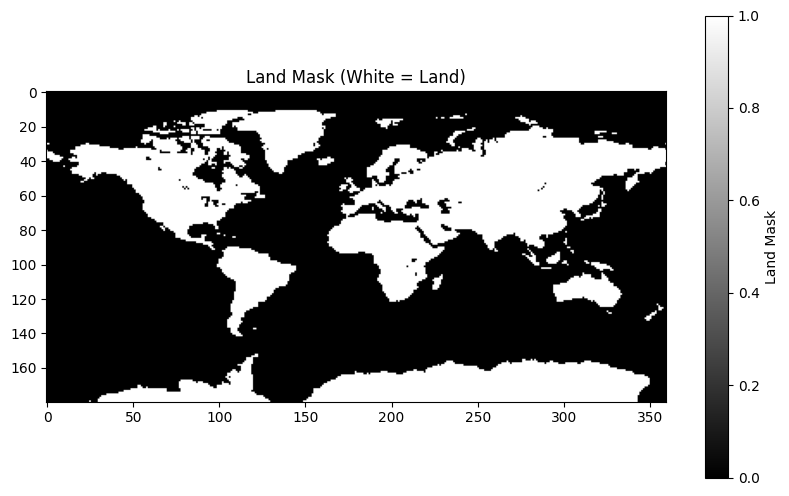

Land mask shape: (180, 360)


<ipython-input-3-272d56cee22c>:77: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  return torch.tensor(inputs, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32)


=== Dataset Splitting Details ===
Total raw time frames (T_raw): 360
Training period ends at raw frame (approx.): 240
Number of training samples: 237
Total number of samples in dataset: 357
--> Train targets: raw frame indices 3 to 239
--> Test targets: raw frame indices 240 to 359

=== Shapes of the Split Datasets ===
Train features shape: torch.Size([237, 3, 4, 180, 360])
Train targets shape: torch.Size([237, 4, 180, 360])
Test features shape: torch.Size([120, 3, 4, 180, 360])
Test targets shape: torch.Size([120, 4, 180, 360])

=== Sample Inspection ===
First training sample input shape: torch.Size([3, 4, 180, 360])
First training sample target shape: torch.Size([4, 180, 360])
Last training sample input shape: torch.Size([3, 4, 180, 360])
Last training sample target shape: torch.Size([4, 180, 360])
First test sample input shape: torch.Size([3, 4, 180, 360])
First test sample target shape: torch.Size([4, 180, 360])
CNNLSTM(
  (cnn_encoder): Sequential(
    (0): Conv2d(4, 64, kernel_si

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import netCDF4
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from scipy.stats import spearmanr
from skimage.transform import resize
import imageio  # for GIF creation

# ============ Device Setup ============
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ============ Multi-Target Data Preprocessing ============
sequence_len = 3

class MultiDepthOceanDataset(Dataset):
    def __init__(self, file_paths, land_mask, sequence_length=sequence_len):
        """
        file_paths: dictionary with keys:
            'SSH', 'SST', 'uSSW', 'vSSW': surface variables (input channels)
            'depth1', 'depth5', 'depth9', 'depth13': depth layers to predict (targets)
        land_mask: binary mask (True for land).
        """
        self.sequence_length = sequence_length
        self.land_mask = land_mask
        self.features, self.targets = self.load_data(file_paths)

    def load_data(self, file_paths):
        def read_var(path, var):
            data = netCDF4.Dataset(path)[var][:].filled(np.nan)
            return data

        # Load input surface variables
        SSH  = read_var(file_paths['SSH'], 'SSH')
        SST  = read_var(file_paths['SST'], 'SST')
        uSSW = read_var(file_paths['uSSW'], 'uSSW')
        vSSW = read_var(file_paths['vSSW'], 'vSSW')

        # Resize surface variables to (T, 180, 360)
        SSH  = resize(SSH,  (SSH.shape[0], 180, 360), preserve_range=True)
        SST  = resize(SST,  (SST.shape[0], 180, 360), preserve_range=True)
        uSSW = resize(uSSW, (uSSW.shape[0], 180, 360), preserve_range=True)
        vSSW = resize(vSSW, (vSSW.shape[0], 180, 360), preserve_range=True)

        # Stack inputs along the channel axis: shape (T, 4, H, W)
        X = np.stack([SSH, SST, uSSW, vSSW], axis=1)

        # Load target depth variables
        depth_keys = ['depth1', 'depth30', 'depth86', 'depth145']
        depths = []
        for key in depth_keys:
            d = read_var(file_paths[key], 'ST')  # assuming the variable name is 'ST'
            d = resize(d, (d.shape[0], 180, 360), preserve_range=True)
            depths.append(d)
        # Stack depths along the channel axis: shape (T, 4, H, W)
        y = np.stack(depths, axis=1)

        # Replace NaNs with zeros for both inputs and targets
        X = np.nan_to_num(X)
        y = np.nan_to_num(y)

        # Normalize the input X with StandardScaler
        T, C, H, W = X.shape  # C = 4 channels
        scaler = StandardScaler()
        X = X.reshape(T, -1)
        X = scaler.fit_transform(X).reshape(T, C, H, W)

        # Create sequences from the time series
        inputs, targets = [], []
        for i in range(self.sequence_length, T):
            inputs.append(X[i - self.sequence_length:i])  # shape: (sequence_length, 4, H, W)
            targets.append(y[i])  # shape: (4, H, W)
        return torch.tensor(inputs, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

# ============ Model Definitions ============
class CNNLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, num_targets,
                 cnn_filters=[64, 128], kernel_size=3, pool_size=2,
                 encoder_size=(180, 360)):
        """
        CNN-LSTM for spatio-temporal forecasting:
          - CNN encoder extracts spatial features per frame
          - LSTM processes sequence of flattened features
          - Linear decoder maps last hidden state to target maps
        encoder_size: spatial size after CNN & pooling
        """
        super(CNNLSTM, self).__init__()
        self.encoder_h, self.encoder_w = encoder_size
        # CNN encoder
        layers = []
        in_ch = input_dim
        for out_ch in cnn_filters:
            layers += [
                nn.Conv2d(in_ch, out_ch, kernel_size, padding=kernel_size//2),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(pool_size)
            ]
            in_ch = out_ch
        self.cnn_encoder = nn.Sequential(*layers)

        # Compute feature size after pooling
        pooled_h = self.encoder_h // (pool_size ** len(cnn_filters))
        pooled_w = self.encoder_w // (pool_size ** len(cnn_filters))
        feat_size = cnn_filters[-1] * pooled_h * pooled_w

        # LSTM on sequence of spatial features
        self.lstm = nn.LSTM(input_size=feat_size,
                            hidden_size=hidden_dim,
                            num_layers=num_layers,
                            batch_first=True)

        # Decoder: map hidden state to full-resolution output
        # we'll upsample via a linear layer + reshape + ConvTranspose if desired
        self.fc = nn.Linear(hidden_dim, num_targets * self.encoder_h * self.encoder_w)

    def forward(self, x):
        # x: (B, T, C, H, W)
        B, T, C, H, W = x.shape
        # encode each time step
        feats = []
        for t in range(T):
            frame = x[:, t]              # (B, C, H, W)
            f = self.cnn_encoder(frame)  # (B, F, H', W')
            feats.append(f.view(B, -1))  # flatten spatial
        seq = torch.stack(feats, dim=1)  # (B, T, feat_size)

        # LSTM
        out_seq, _ = self.lstm(seq)      # (B, T, hidden_dim)
        last_h = out_seq[:, -1]          # (B, hidden_dim)

        # Decode
        out = self.fc(last_h)            # (B, num_targets*H*W)
        out = out.view(B, -1, self.encoder_h, self.encoder_w)
        return out

# ============ Training and Testing Loops ============
def train_model(model, train_loader, test_loader, land_mask, epochs=20):
    l = []
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss(reduction='none')
    model.to(device)
    # Prepare land mask tensor with shape (1, 1, H, W)
    land_mask_tensor = torch.tensor(land_mask, dtype=torch.bool).unsqueeze(0).unsqueeze(0).to(device)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            B = outputs.size(0)
            # Expand land mask to match output dimensions
            land_mask_expanded = land_mask_tensor.expand(B, outputs.size(1), -1, -1)
            ocean_mask = ~land_mask_expanded
            loss_map = criterion(outputs[ocean_mask], targets[ocean_mask])
            loss = loss_map.mean()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        l.append(total_loss/len(train_loader))
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")
    return l

def test_model(model, test_loader, land_mask):
    model.eval()
    pred_list = []
    true_list = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            preds = model(inputs)
            pred_list.append(preds.cpu().numpy())
            true_list.append(targets.cpu().numpy())
    pred_array = np.concatenate(pred_list, axis=0)  # (N, 4, H, W)
    true_array = np.concatenate(true_list, axis=0)
    land_mask_bool = land_mask.astype(bool)
    spearman_scores = []
    for i in range(pred_array.shape[0]):
        channel_scores = []
        for ch in range(pred_array.shape[1]):
            pred = pred_array[i, ch]
            true = true_array[i, ch]
            ocean_mask = ~land_mask_bool
            valid_preds = pred[ocean_mask]
            valid_true = true[ocean_mask]
            score, _ = spearmanr(valid_preds, valid_true)
            channel_scores.append(score)
        spearman_scores.append(np.mean(channel_scores))
    print(f"Average Spearman correlation over ocean: {np.nanmean(spearman_scores):.4f}")

    # Plot predictions for the first sample as default
    depth_names = ['Depth 1', 'Depth 30', 'Depth 86', 'Depth 145']
    num_targets = pred_array.shape[1]
    fig, axs = plt.subplots(num_targets, 2, figsize=(12, 3 * num_targets))
    for i in range(num_targets):
        im_pred = axs[i, 0].imshow(np.flipud(np.ma.masked_where(land_mask_bool, pred_array[0, i])), cmap='inferno')
        axs[i, 0].set_title(f"Predicted {depth_names[i]}")
        fig.colorbar(im_pred, ax=axs[i, 0])
        im_true = axs[i, 1].imshow(np.flipud(np.ma.masked_where(land_mask_bool, true_array[0, i])), cmap='inferno')
        axs[i, 1].set_title(f"True {depth_names[i]}")
        fig.colorbar(im_true, ax=axs[i, 1])
    plt.tight_layout()
    plt.show()

# ============ Additional Functions for Output ============
def save_predictions_to_netcdf(prediction_years, nc_filename='predictions2.nc'):
    """
    Save a list of (year, prediction) tuples as a NetCDF file.
    The predicted array is assumed to have shape (4, H, W).
    """
    years = [yr for yr, _ in prediction_years]
    predictions = np.stack([pred for _, pred in prediction_years], axis=0)  # shape: (n_time, 4, H, W)

    nc = netCDF4.Dataset(nc_filename, 'w', format='NETCDF4')
    nc.createDimension('time', len(years))
    nc.createDimension('depth', predictions.shape[1])
    nc.createDimension('lat', predictions.shape[2])
    nc.createDimension('lon', predictions.shape[3])

    time_var = nc.createVariable('time', 'i4', ('time',))
    depth_var = nc.createVariable('depth', 'i4', ('depth',))
    lat_var = nc.createVariable('lat', 'f4', ('lat',))
    lon_var = nc.createVariable('lon', 'f4', ('lon',))
    pred_var = nc.createVariable('prediction', 'f4', ('time', 'depth', 'lat', 'lon'))

    time_var.units = 'year'
    depth_var.units = 'depth level'
    lat_var.units = 'degrees_north'
    lon_var.units = 'degrees_east'

    time_var[:] = years
    depth_var[:] = np.arange(1, predictions.shape[1] + 1)
    lat_var[:] = np.linspace(-90, 90, predictions.shape[2])
    lon_var[:] = np.linspace(-180, 180, predictions.shape[3])
    pred_var[:] = predictions

    nc.close()
    print(f"Saved predicted data to {nc_filename}")

def create_prediction_gif(prediction_years, land_mask_bool, gif_filename='predictions.gif'):
    """
    Create an animated GIF from the predictions.
    Uses the first predicted channel (Depth 1) to create a frame for each year.
    """
    frames = []
    for yr, pred in prediction_years:
        fig, ax = plt.subplots()
        im = ax.imshow(
            np.flipud(np.ma.masked_where(land_mask_bool, pred[0])),
            cmap='inferno'
        )
        ax.set_title(f"Predicted Depth 1 for Year ~ {yr}")
        fig.colorbar(im, ax=ax)

        # Draw the canvas and grab the RGBA buffer
        fig.canvas.draw()
        buf, (w, h) = fig.canvas.print_to_buffer()
        # buf is RGBA uint8, reshape to (h, w, 4)
        image = np.frombuffer(buf, dtype=np.uint8).reshape(h, w, 4)[..., :3]
        frames.append(image)

        plt.close(fig)

    # Save frames as an animated GIF
    imageio.mimsave(gif_filename, frames, fps=1)
    print(f"Saved GIF: {gif_filename}")


def evaluate_and_save_predictions_by_year(model, test_dataset, land_mask,
                                          train_split_idx, sequence_len, T_raw,
                                          start_year=1992, end_year=2021):
    """
    For each unique integer year in the test period, select the first test sample,
    run prediction, plot the results, and collect the predictions.
    Then save all predictions to a NetCDF file and create a GIF.
    """
    model.eval()
    year_to_sample = {}
    total_test_samples = len(test_dataset)
    for i in range(total_test_samples):
        # Map test sample index to raw frame index:
        raw_index = train_split_idx + sequence_len + i
        estimated_year = start_year + (raw_index / (T_raw - 1)) * (end_year - start_year)
        estimated_year_int = int(round(estimated_year))
        if estimated_year_int not in year_to_sample:
            year_to_sample[estimated_year_int] = i

    print("Selected test samples for years:", sorted(year_to_sample.keys()))
    land_mask_bool = land_mask.astype(bool)
    depth_names = ['Depth 1', 'Depth 30', 'Depth 86', 'Depth 145']
    predictions_by_year = []  # list of tuples (year, prediction)

    for yr in sorted(year_to_sample.keys()):
        sample_idx = year_to_sample[yr]
        sample_input, sample_target = test_dataset[sample_idx]
        sample_input = sample_input.unsqueeze(0).to(device)
        with torch.no_grad():
            pred = model(sample_input).cpu().numpy()[0]  # shape: (4, H, W)
        predictions_by_year.append((yr, pred))

        # Plot predictions vs. target for visual inspection
        fig, axs = plt.subplots(len(depth_names), 2, figsize=(12, 3 * len(depth_names)))
        fig.suptitle(f"Predictions for Year ~ {yr}", fontsize=16)
        for i in range(len(depth_names)):
            im_pred = axs[i, 0].imshow(np.flipud(np.ma.masked_where(land_mask_bool, pred[i])), cmap='inferno')
            axs[i, 0].set_title(f"Predicted {depth_names[i]}")
            fig.colorbar(im_pred, ax=axs[i, 0])
            im_true = axs[i, 1].imshow(np.flipud(np.ma.masked_where(land_mask_bool, sample_target.numpy()[i])), cmap='inferno')
            axs[i, 1].set_title(f"True {depth_names[i]}")
            fig.colorbar(im_true, ax=axs[i, 1])
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

    # Save predictions to a NetCDF file
    save_predictions_to_netcdf(predictions_by_year, nc_filename='predictions2.nc')
    # Create an animated GIF from the predictions (using Depth 1)
    create_prediction_gif(predictions_by_year, land_mask_bool, gif_filename='predictions.gif')

# ============ Create Binary Land Mask ============
def create_land_mask_2(st_file_path='/content/drive/MyDrive/661 Final Project/project_SST_1992-2021.nc', shape=(180, 360)):
    ds = netCDF4.Dataset(st_file_path)
    st_data_full = ds.variables['SST'][:]
    st_data_full = np.ma.filled(st_data_full, fill_value=0)
    resized_frames = [resize(frame, shape, preserve_range=True) for frame in st_data_full]
    st_resized_full = np.stack(resized_frames)
    st_mean = np.mean(st_resized_full, axis=0)
    land_mask = st_mean < 1e2
    return land_mask

# ============ Setup File Paths and Land Mask ============
file_paths = {
    'SSH': '/content/drive/MyDrive/661 Final Project/project_SSH_1992-2021.nc',
    'SST': '/content/drive/MyDrive/661 Final Project/project_SST_1992-2021.nc',
    'uSSW': '/content/drive/MyDrive/661 Final Project/project_uSSW_1992-2021.nc',
    'vSSW': '/content/drive/MyDrive/661 Final Project/project_vSSW_1992-2021.nc',
    'depth1': '/content/drive/MyDrive/661 Final Project/project_ST_1992-2021_dep-1.nc',
    'depth5': '/content/drive/MyDrive/661 Final Project/project_ST_1992-2021_dep-5.nc',
    'depth9': '/content/drive/MyDrive/661 Final Project/project_ST_1992-2021_dep-9.nc',
    'depth13': '/content/drive/MyDrive/661 Final Project/project_ST_1992-2021_dep-13.nc',
    'depth30': '/content/drive/MyDrive/661 Final Project/project_ST_1992-2021_dep-30.nc',
    'depth56': '/content/drive/MyDrive/661 Final Project/project_ST_1992-2021_dep-56.nc',
    'depth86': '/content/drive/MyDrive/661 Final Project/project_ST_1992-2021_dep-86.nc',
    'depth100': '/content/drive/MyDrive/661 Final Project/project_ST_1992-2021_dep-100.nc',
    'depth145': '/content/drive/MyDrive/661 Final Project/project_ST_1992-2021_dep-145.nc'
}

land_mask = create_land_mask_2()
plt.figure(figsize=(10, 6))
plt.imshow(np.flipud(land_mask), cmap='gray')
plt.title("Land Mask (White = Land)")
plt.colorbar(label='Land Mask')
plt.show()
print("Land mask shape:", land_mask.shape)

# ============ Time-based Train/Test Split ============
# Create the full dataset from the NetCDF files
full_dataset = MultiDepthOceanDataset(file_paths, land_mask, sequence_length=sequence_len)
# Total raw frames = number of samples + sequence_len (because samples start at index sequence_len)
T_raw = len(full_dataset.features) + sequence_len

# Since data spans 1992-2021 (30 years), use the first 20 years for training and the last 10 for testing.
train_end_frame = int(T_raw * 20 / 30)      # raw frame index at the end of training period
train_split_idx = train_end_frame - sequence_len  # number of training samples

print("=== Dataset Splitting Details ===")
print(f"Total raw time frames (T_raw): {T_raw}")
print(f"Training period ends at raw frame (approx.): {train_end_frame}")
print(f"Number of training samples: {train_split_idx}")
print(f"Total number of samples in dataset: {len(full_dataset)}")
print(f"--> Train targets: raw frame indices {sequence_len} to {train_split_idx + sequence_len - 1}")
print(f"--> Test targets: raw frame indices {train_split_idx + sequence_len} to {T_raw - 1}")

train_features = full_dataset.features[:train_split_idx]
train_targets  = full_dataset.targets[:train_split_idx]
test_features = full_dataset.features[train_split_idx:]
test_targets  = full_dataset.targets[train_split_idx:]

train_dataset = TensorDataset(train_features, train_targets)
test_dataset  = TensorDataset(test_features, test_targets)

print("\n=== Shapes of the Split Datasets ===")
print("Train features shape:", train_features.shape)
print("Train targets shape:", train_targets.shape)
print("Test features shape:", test_features.shape)
print("Test targets shape:", test_targets.shape)

print("\n=== Sample Inspection ===")
print("First training sample input shape:", train_features[0].shape)
print("First training sample target shape:", train_targets[0].shape)
print("Last training sample input shape:", train_features[-1].shape)
print("Last training sample target shape:", train_targets[-1].shape)
print("First test sample input shape:", test_features[0].shape)
print("First test sample target shape:", test_targets[0].shape)

batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# ============ Initialize Model ============
model = CNNLSTM(
    input_dim=4,
    hidden_dim=256,
    num_layers=2,
    num_targets=4,
    cnn_filters=[64, 128],
    kernel_size=3,
    pool_size=2,
    encoder_size=(180, 360)
).to(device)
# model = DepthCNN(seq_len=3, in_channels=4,
#                  hidden_dim=32).to(device)
# print(model)

# ============ Run Training ============
loss = train_model(model, train_loader, test_loader, land_mask, epochs=10)

# ============ Evaluate, Save, and Create GIF from Predictions ============
evaluate_and_save_predictions_by_year(model, test_dataset, land_mask,
                                      train_split_idx=train_split_idx, sequence_len=sequence_len, T_raw=T_raw,
                                      start_year=1992, end_year=2021)

# import matplotlib.pyplot as plt
# plt.figure(figsize=(10, 6))
# plt.plot(loss)
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Training Loss Over Epochs')
# plt.show()

Average Spearman correlation over ocean: 0.9685


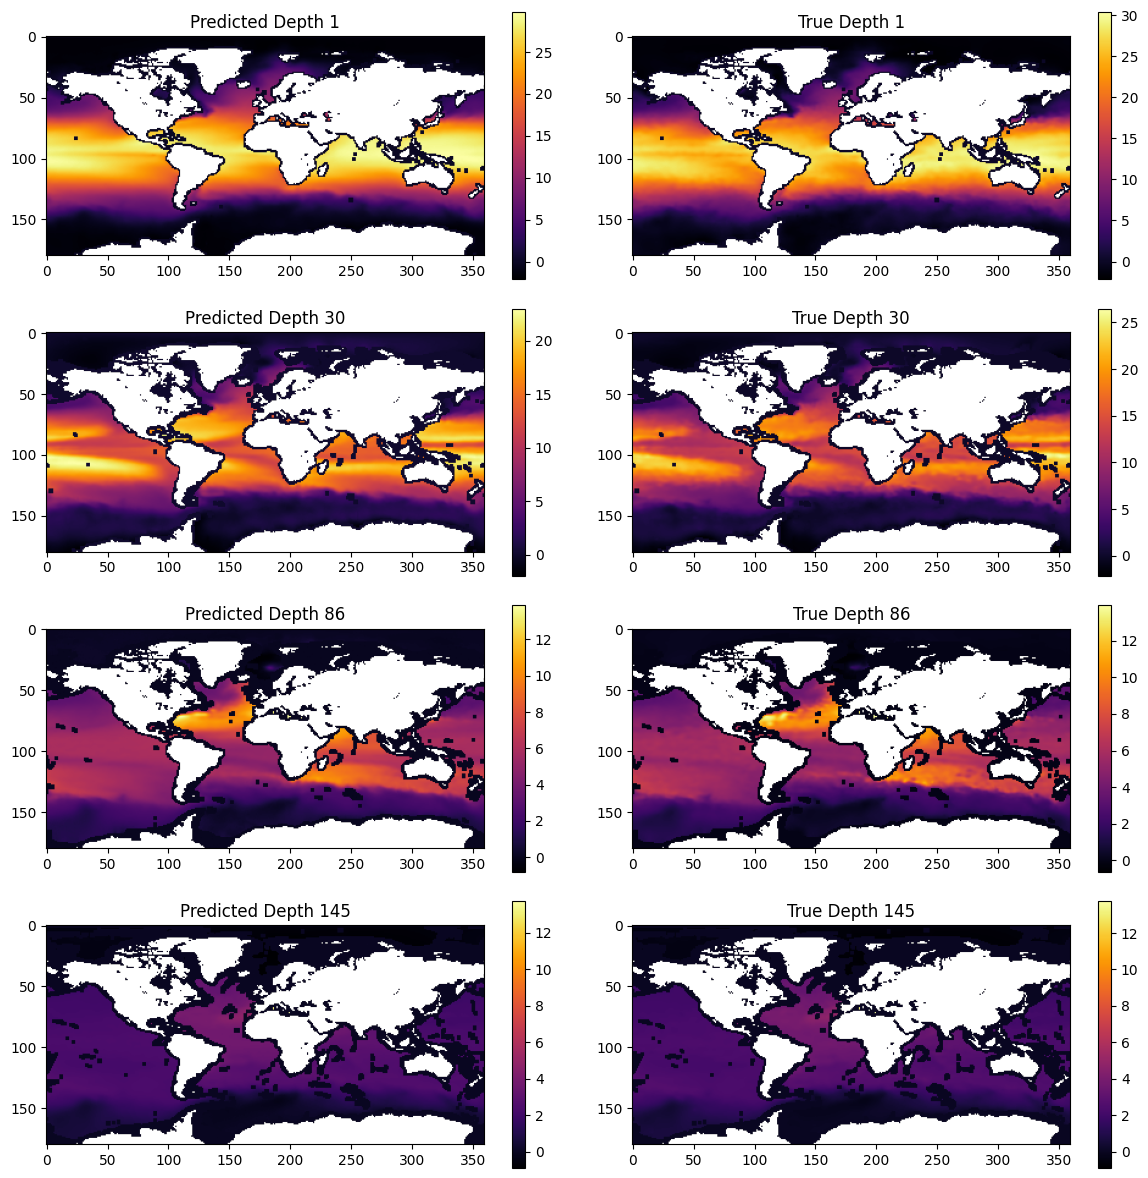

In [ ]:
avg_rhos = test_model(model, test_loader, land_mask)
